<a href="https://colab.research.google.com/github/T1mSan1ch/resnet_cifar10/blob/main/resnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задачу классификации на датасете CIFAR-10


## Предобработка данных

In [ ]:
import torch
import torchvision.datasets
import random
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


Загрузим набор данных CIFAR10.

In [ ]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 60197872.03it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
len(y_train), len(y_test)

(50000, 10000)

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Нормируем данные и посмотрим на первые 10 классов.

In [ ]:
X_train /= 255.
X_test /= 255.

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

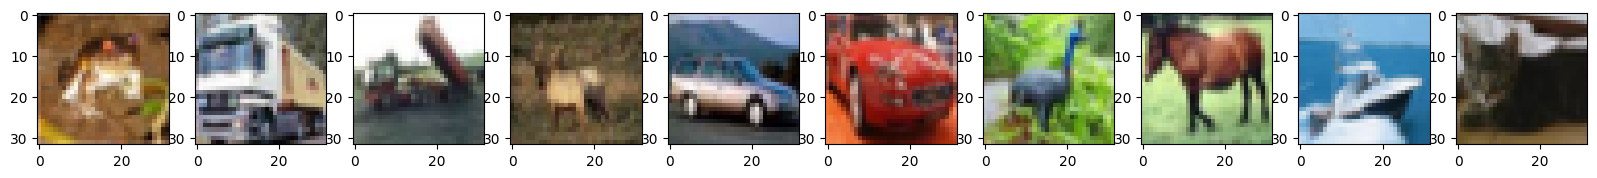

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')


Реорганизуем тензор наших данных, чтобы с ним можно было работать в pytorch.  Приведем его к виду \[Число изображений,  число каналов, высота изображения, ширина изображения].

In [ ]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
X_train.shape

torch.Size([50000, 3, 32, 32])

Опишем процесс обучения.

In [ ]:
def train(net, X_train, y_train, X_test, y_test, batch_size=256, epoch_num=50, epoch_info_show=10,\
          weight_decay=0, save_net_state=False, verbose=True):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, \
                                 weight_decay=weight_decay)


    t = time.time()
    test_accuracy_history = []
    test_loss_history = []


    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(1, epoch_num+1):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()


        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          loss_value = loss(test_preds, y_test).item()
          test_loss_history.append(loss_value)

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)

          if verbose:
            if epoch % epoch_info_show == 0:
              print('Train Epoch: {} Time: {} Accuracy: {}, GPU_Mem_alloc: {} GPU_Mem_cashed: {}'\
                  .format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy, \
                            torch.cuda.memory_allocated(), torch.cuda.memory_cached()))

    net_state = net.state_dict()
    del net
    if save_net_state:
      return test_accuracy_history, test_loss_history, net_state
    else:
      return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

Построение графиков.

In [ ]:
plt.style.use(['ggplot', 'dark_background'])
#sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def acc_loss_graph(accuracies, losses, net_list, save_file_name='plot.png', download=False):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  for experiment_id in net_list:
      ax1.plot(accuracies[experiment_id], label=experiment_id)
  ax1.legend()
  ax1.set_title('Validation Accuracy')
  fig.tight_layout()

  for experiment_id in net_list:

      ax2.plot(losses[experiment_id], label=experiment_id)
  ax2.legend()
  ax2.set_title('Validation Loss');

  fig.tight_layout()

  if download:
    fig.savefig(save_file_name)
#     files.download(save_file_name) #для загрузски с Colab

## CIFARNet

Для начала возьмем  [CIFARNet](https://github.com/SlinkoIgor/Neural_Networks_and_CV/blob/master/module06_cifar.ipynb).

In [ ]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)

        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.fc3   = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)

        return x

Обучим сеть CIFARNet,  также загрузим и обучим resnet18(написанная для датасета ImageNet)

In [ ]:
accuracies['cifar_net'], losses['cifar_net'] = train(CIFARNet(), X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:416: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Train Epoch: 10 Time: 00:00:22 Accuracy: 0.6998999714851379, GPU_Mem_alloc: 159719424 GPU_Mem_cashed: 1742733312
Train Epoch: 20 Time: 00:00:36 Accuracy: 0.7009999752044678, GPU_Mem_alloc: 159719424 GPU_Mem_cashed: 1742733312
Train Epoch: 30 Time: 00:00:51 Accuracy: 0.7013999819755554, GPU_Mem_alloc: 159719424 GPU_Mem_cashed: 1742733312
Train Epoch: 40 Time: 00:01:06 Accuracy: 0.7037000060081482, GPU_Mem_alloc: 159719424 GPU_Mem_cashed: 1742733312
Train Epoch: 50 Time: 00:01:21 Accuracy: 0.7027999758720398, GPU_Mem_alloc: 159719424 GPU_Mem_cashed: 1742733312


In [ ]:
from torchvision.models import resnet18

accuracies['resnet18'], losses['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:01:23 Accuracy: 0.6811999678611755, GPU_Mem_alloc: 371364352 GPU_Mem_cashed: 3256877056
Train Epoch: 20 Time: 00:02:44 Accuracy: 0.732699990272522, GPU_Mem_alloc: 371364352 GPU_Mem_cashed: 3256877056
Train Epoch: 30 Time: 00:04:07 Accuracy: 0.7258999943733215, GPU_Mem_alloc: 371364352 GPU_Mem_cashed: 3256877056
Train Epoch: 40 Time: 00:05:29 Accuracy: 0.7143999934196472, GPU_Mem_alloc: 371364352 GPU_Mem_cashed: 3256877056
Train Epoch: 50 Time: 00:06:50 Accuracy: 0.746399998664856, GPU_Mem_alloc: 371364352 GPU_Mem_cashed: 3256877056


## ResNet
Создадим ResNet([оригинальная статья](https://arxiv.org/pdf/1512.03385.pdf)) для решения задачи CIFAR10 [Код](https://github.com/akamaster/pytorch_resnet_cifar10) - аналогичен за исключением нескольких модификаций и инициализации весов, а так же используется небольшая модификация для датасета CIFAR10.

In [ ]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A',
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """https://www.kaggle.com/mrtahion/kernel63a29c282a?scriptVersionId=17181076
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)
        out = self.act(out)
        out = self.conv2(out)

        if self.use_batch_norm:
          out = self.bn2(out)
        if self.use_drop_out:
          out = self.d_out2(out)

        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               use_drop_out=self.use_drop_out,
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)

        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


Модификации сети, которые пригодятся в дальнейшем.

In [ ]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])

def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False)

def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)

def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)

def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)

def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)

def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

## ResNet20
Обучим ResNet20.

In [ ]:
accuracies['resnet20'], losses['resnet20'] = train(resnet20(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:06 Accuracy: 0.7170999646186829, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6043992064
Train Epoch: 20 Time: 00:04:12 Accuracy: 0.761199951171875, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6043992064
Train Epoch: 30 Time: 00:06:18 Accuracy: 0.7680999636650085, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6043992064
Train Epoch: 40 Time: 00:08:23 Accuracy: 0.7708999514579773, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6043992064
Train Epoch: 50 Time: 00:10:29 Accuracy: 0.8000999689102173, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6043992064


Сравним результаты всех трех сетей: ResNet20, Resnet18 и CIFARNet.

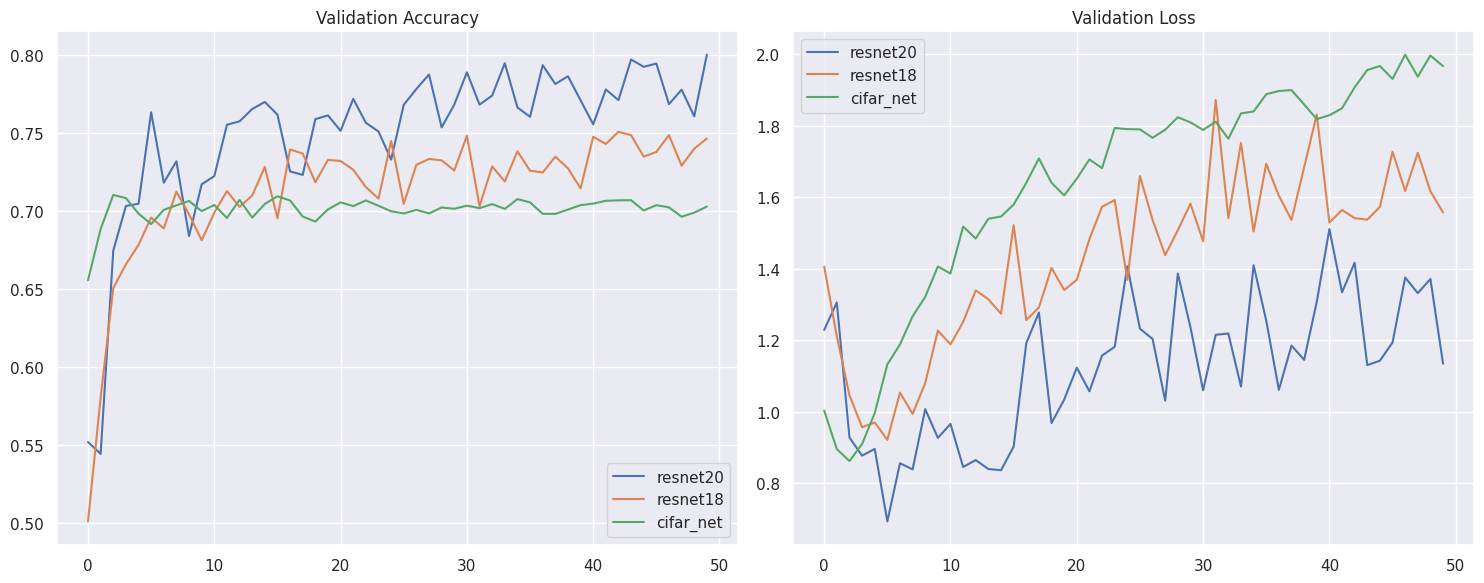

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet18', 'cifar_net'])

Как и следовало ожидать, Resnet18 превосходит CIFARNet, но уступает ResNet20(в том числе и во времени обучения).

## ResNet110 и batch normalization.
Теперь обучим ResNet110 в изначальном варианте и в варианте с отключеными BatchNorm слоями.
Для обучения я снизил размер батча до 64.


In [ ]:
accuracies['resnet110'], losses['resnet110'] = \
    train(resnet110(), X_train, y_train, X_test, y_test, batch_size=64)

Train Epoch: 10 Time: 00:12:01 Accuracy: 0.8141999840736389, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:23:45 Accuracy: 0.8216999769210815, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:35:29 Accuracy: 0.8188999891281128, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:47:13 Accuracy: 0.8359999656677246, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:58:57 Accuracy: 0.8212999701499939, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = \
    train(resnet110_no_bn(), X_train, y_train, X_test, y_test, batch_size=64)

Train Epoch: 10 Time: 00:09:58 Accuracy: 0.6682999730110168, GPU_Mem_alloc: 169250304 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:19:54 Accuracy: 0.6990999579429626, GPU_Mem_alloc: 169250304 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:29:48 Accuracy: 0.7014999985694885, GPU_Mem_alloc: 169250304 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:39:40 Accuracy: 0.7116000056266785, GPU_Mem_alloc: 169250304 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:49:31 Accuracy: 0.7168999910354614, GPU_Mem_alloc: 169250304 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20 bs=64'], losses['resnet20 bs=64'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, batch_size=64)

Train Epoch: 10 Time: 00:02:05 Accuracy: 0.799299955368042, GPU_Mem_alloc: 145853952 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:11 Accuracy: 0.8055999875068665, GPU_Mem_alloc: 145853952 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:16 Accuracy: 0.790399968624115, GPU_Mem_alloc: 145853952 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:22 Accuracy: 0.8173999786376953, GPU_Mem_alloc: 145853952 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:28 Accuracy: 0.8170999884605408, GPU_Mem_alloc: 145853952 GPU_Mem_cashed: 6169821184


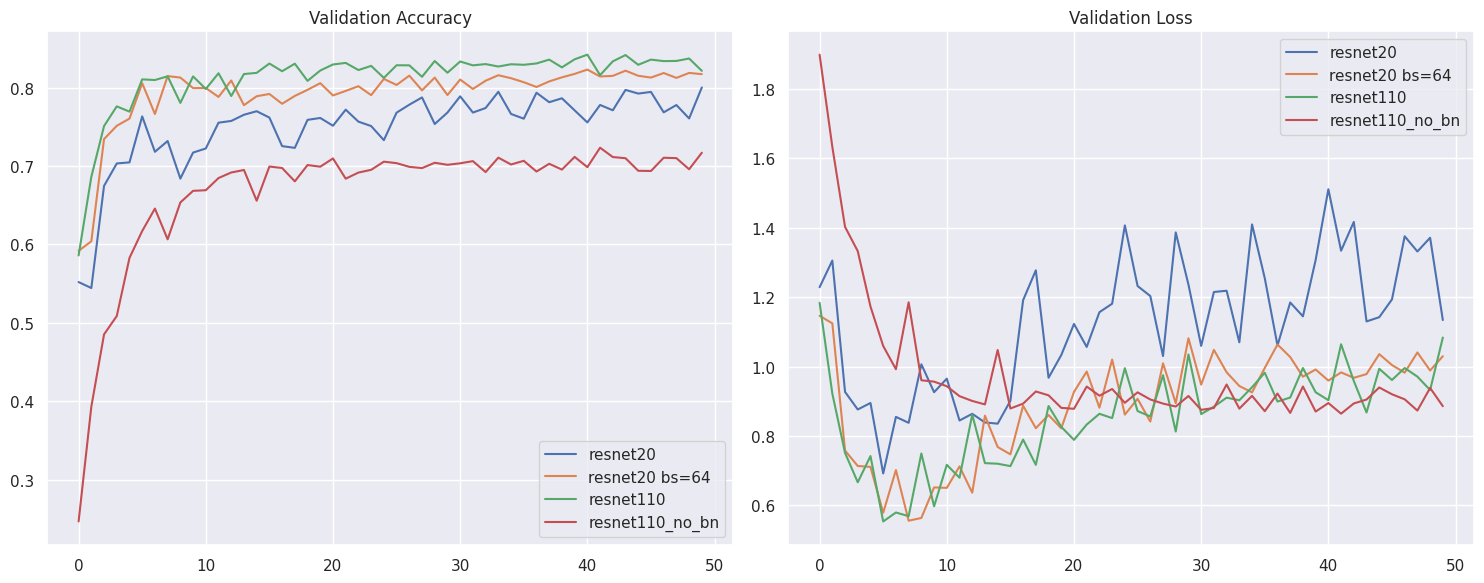

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20','resnet20 bs=64', 'resnet110', 'resnet110_no_bn'])

На графиках мы можем видеть, что ResNet110 превосходит Resnet20. При отключении BatchNorm сеть перестает эффективно обучатся.

Cтоит отметить, что уменьшение размера батча положительно повлияло на результаты ResNet20.
Маленький батч дает больше рандомности в градиентный спуск. Что позволяет, например, избегать локальных минимумов: для каждого батча ближайший минимум, к которому он сходится, свой. Чем меньше батч - тем сильнее его ближайший минимум отличается от таковых у соседних батчей.

## DropOut
Посмотрим как будет вести себя сеть ResNet20, если после каждого слоя BatchNorm добавить слой Dropout c различными значениями параметра p.

In [ ]:
accuracies['resnet20_d_out p=0.5'], losses['resnet20_d_out p=0.5'] = \
    train(resnet20_d_out5(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:03 Accuracy: 0.43479999899864197, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:11 Accuracy: 0.5151000022888184, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:20 Accuracy: 0.5837999582290649, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:30 Accuracy: 0.6128999590873718, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:40 Accuracy: 0.6360999941825867, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20_d_out p=0.3'], losses['resnet20_d_out p=0.3'] = \
    train(resnet20_d_out3(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:10 Accuracy: 0.6184999942779541, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:21 Accuracy: 0.7328999638557434, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:32 Accuracy: 0.7691999673843384, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:42 Accuracy: 0.7963999509811401, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:53 Accuracy: 0.8072999715805054, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20_d_out p=0.8'], losses['resnet20_d_out p=0.8'] = \
    train(resnet20_d_out8(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:07 Accuracy: 0.14919999241828918, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:15 Accuracy: 0.2044999897480011, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:22 Accuracy: 0.25360000133514404, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:30 Accuracy: 0.2637999951839447, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:37 Accuracy: 0.26819998025894165, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20_d_out p=0.15'], losses['resnet20_d_out p=0.15'] = \
    train(resnet20_d_out15(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:11 Accuracy: 0.7561999559402466, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:22 Accuracy: 0.8209999799728394, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:33 Accuracy: 0.8339999914169312, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:44 Accuracy: 0.8398000001907349, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:55 Accuracy: 0.8420000076293945, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


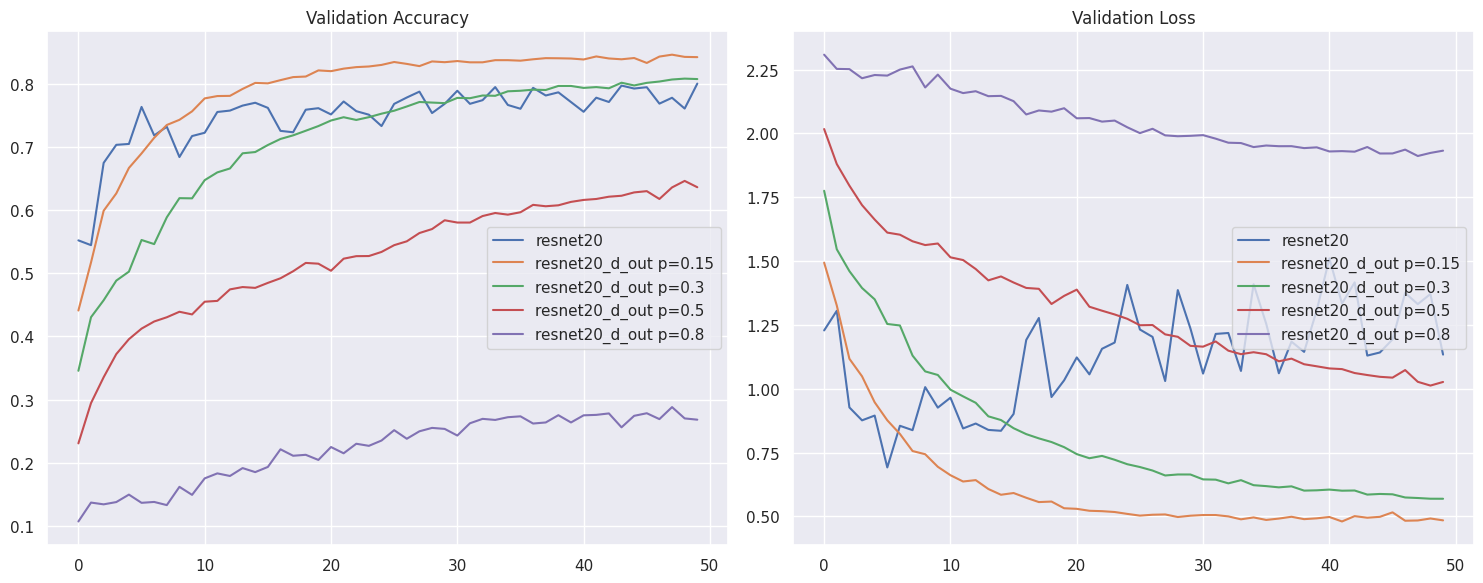

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20_d_out p=0.15', 'resnet20_d_out p=0.3',\
                                    'resnet20_d_out p=0.5', 'resnet20_d_out p=0.8' ])

На графиках можно увидеть, что при больших значениях параметра p сеть перестает эффективно обучатся. С уменьшением значения параметра слоев DropOut результаты приближаются к оригинальной сети.
И при значении *p=0.15* результат  превосходит результат сети без DropOut слоев.  При этом не наступает переобучения на заданном промежутке.
Так же стоит заметить что график с оптимальным значением *p* более "гладкий"

## L2-регуляризация


Посмотрим как повлияет на работу ResNet20  применение l2-регуляризации

In [ ]:
accuracies['resnet20 wd=1e-5'], losses['resnet20 wd=1e-5'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-5)

Train Epoch: 10 Time: 00:01:59 Accuracy: 0.7501999735832214, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:02 Accuracy: 0.7669000029563904, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:06 Accuracy: 0.755299985408783, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:11 Accuracy: 0.7555999755859375, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:16 Accuracy: 0.7685999870300293, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20 wd=1e-4'], losses['resnet20 wd=1e-4'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-4)

Train Epoch: 10 Time: 00:02:05 Accuracy: 0.7634999752044678, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:11 Accuracy: 0.7545999884605408, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:16 Accuracy: 0.7493000030517578, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:22 Accuracy: 0.7649999856948853, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:28 Accuracy: 0.7615999579429626, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20 wd=1e-3'], losses['resnet20 wd=1e-3'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-3)

Train Epoch: 10 Time: 00:02:05 Accuracy: 0.7681999802589417, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:11 Accuracy: 0.7360999584197998, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:17 Accuracy: 0.7698999643325806, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:23 Accuracy: 0.7348999977111816, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:29 Accuracy: 0.7495999932289124, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20 wd=1e-2'], losses['resnet20 wd=1e-2'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-2)

Train Epoch: 10 Time: 00:02:05 Accuracy: 0.7489999532699585, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:11 Accuracy: 0.7199999690055847, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:16 Accuracy: 0.6502999663352966, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:22 Accuracy: 0.7639999985694885, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:10:27 Accuracy: 0.7597000002861023, GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 6169821184


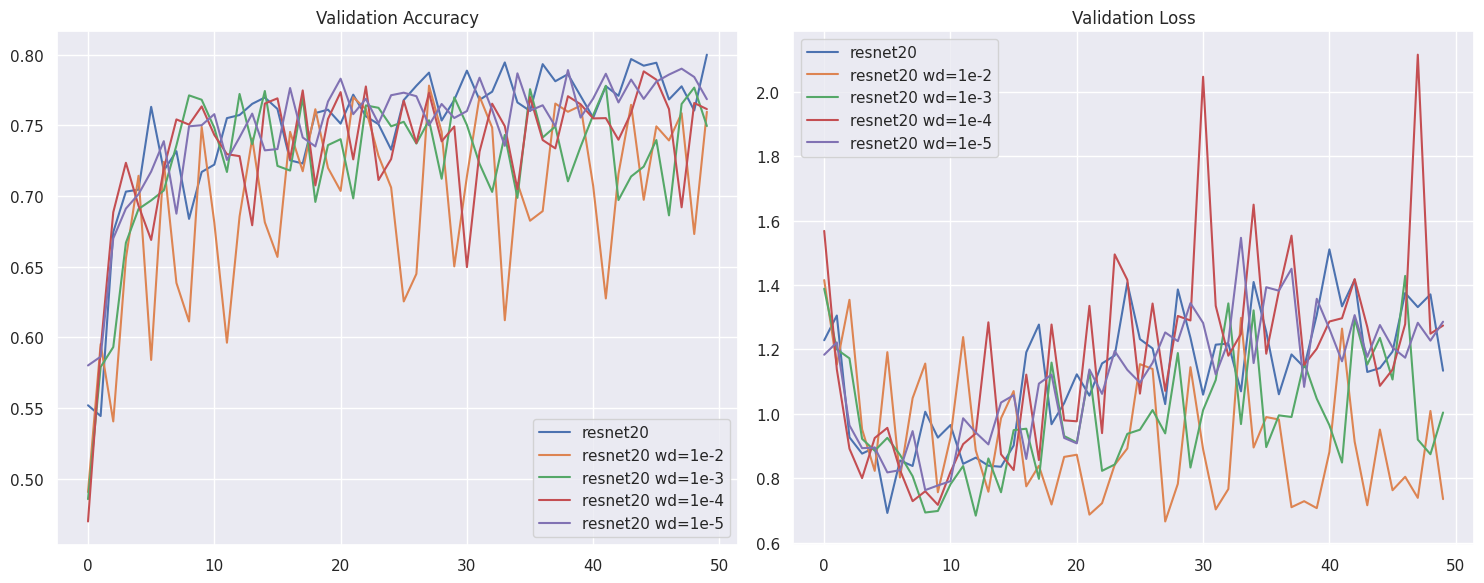

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20 wd=1e-2', 'resnet20 wd=1e-3','resnet20 wd=1e-4',
                                    'resnet20 wd=1e-5'])

Применение l2-регуляризации не принесло положительных изменений. При больших значениях коэффициента регуляризации сеть, ожидаемо, демонстрирует худший результат.

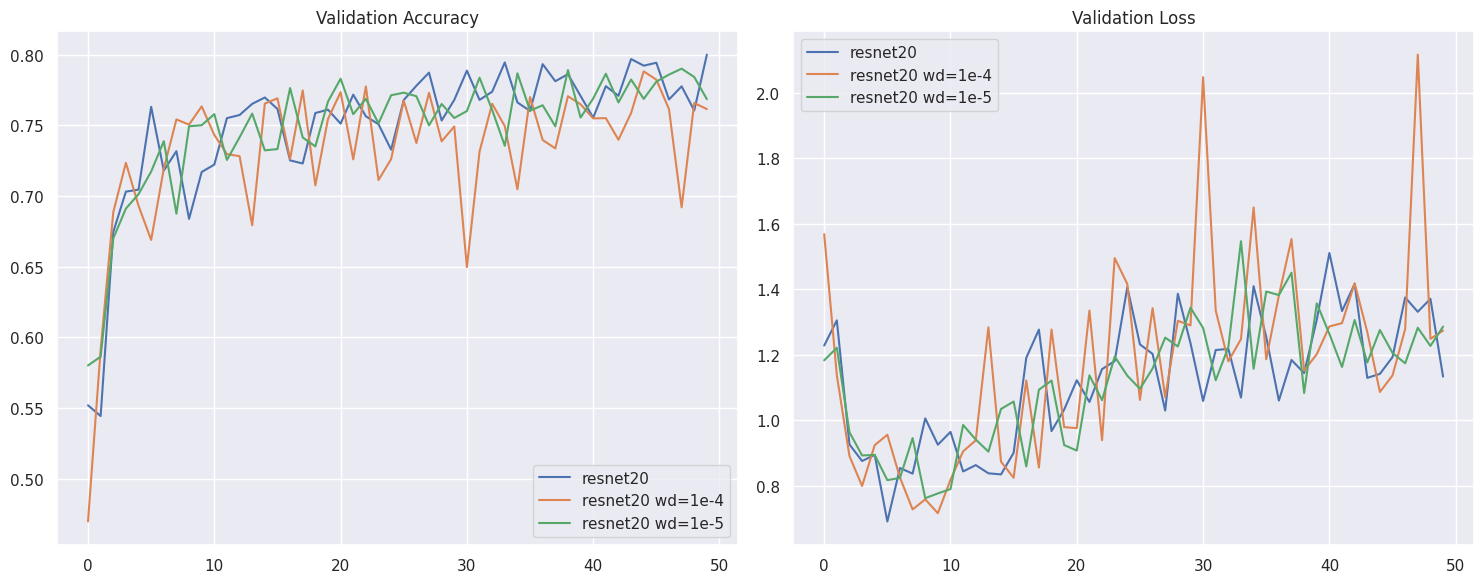

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20','resnet20 wd=1e-4', 'resnet20 wd=1e-5'])

## Сделаю наилучшие версии
ResNet110 показал себя несколько лучше, чем ResNet20. И можно ожидать, что модифицуруя ResNet110 также, как и ResNet20, я ещё улучшил точность предсказания.


In [ ]:
accuracies['resnet110_d_out15'], losses['resnet110_d_out15'], resnet110_d_out15_state = \
    train(resnet110_d_out15(), X_train, y_train, X_test, y_test, batch_size=64, save_net_state=True)

Train Epoch: 10 Time: 00:12:25 Accuracy: 0.8176999688148499, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:24:51 Accuracy: 0.8463000059127808, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:37:18 Accuracy: 0.8536999821662903, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:49:42 Accuracy: 0.852899968624115, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 01:02:10 Accuracy: 0.8515999913215637, GPU_Mem_alloc: 169585152 GPU_Mem_cashed: 6169821184


In [ ]:
accuracies['resnet20_d_out p=0.15 bs=64'], losses['resnet20_d_out p=0.15 bs=64'], resnet20_d_out15_state = \
    train(resnet20_d_out15(), X_train, y_train, X_test, y_test, batch_size=64, save_net_state=True)

Train Epoch: 10 Time: 00:02:14 Accuracy: 0.7889999747276306, GPU_Mem_alloc: 153013248 GPU_Mem_cashed: 6169821184
Train Epoch: 20 Time: 00:04:28 Accuracy: 0.8277999758720398, GPU_Mem_alloc: 153013248 GPU_Mem_cashed: 6169821184
Train Epoch: 30 Time: 00:06:42 Accuracy: 0.8411999940872192, GPU_Mem_alloc: 153013248 GPU_Mem_cashed: 6169821184
Train Epoch: 40 Time: 00:08:56 Accuracy: 0.8481999635696411, GPU_Mem_alloc: 153013248 GPU_Mem_cashed: 6169821184
Train Epoch: 50 Time: 00:11:11 Accuracy: 0.851099967956543, GPU_Mem_alloc: 153013248 GPU_Mem_cashed: 6169821184


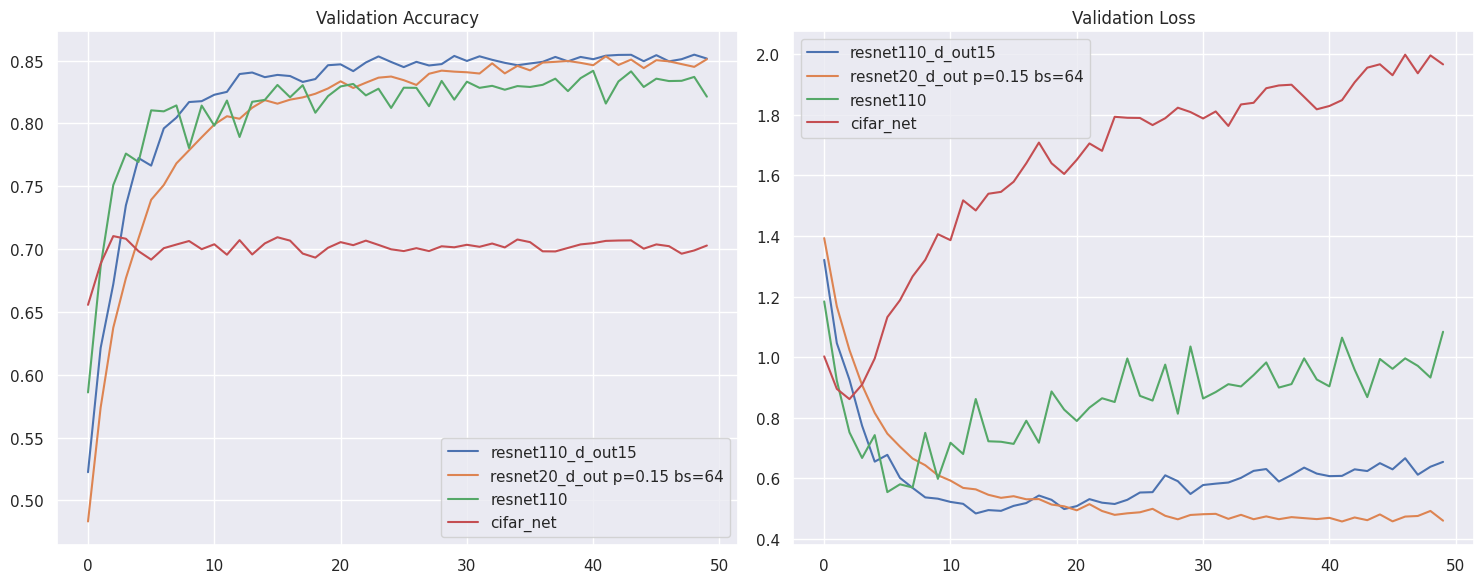

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet110_d_out15','resnet20_d_out p=0.15 bs=64', 'resnet110', 'cifar_net'])

Включение DropOut в ResNet110 не принесло значимых улучшений, в сравнении с ResNet20.

## Заключение

Мы протестировали несколько различных архитектур ResNet и их модификаций, заметно превзлошли результаты CIFARNet.

Попытайтесь превзойти данный результат путем:
- дальнейшей модификации архитектуры,
- использования более продвинутых архитектур нейронных сетей,
- приманения аугментации,
- создания ансамбля из несколький сетей,
- и тд.

![](https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg)